In [6]:
%pip install --upgrade pip
%pip install -r requirements.txt
%pip install scikit-learn

import sklearn as sk  
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

Note: you may need to restart the kernel to use updated packages.
  Using cached tensorflow-2.18.0-cp310-cp310-macosx_12_0_arm64.whl.metadata (4.0 kB)
  Using cached tensorboard-2.18.0-py3-none-any.whl.metadata (1.6 kB)
INFO: pip is looking at multiple versions of tensorflow to determine which version is compatible with other requirements. This could take a while.
ERROR: Cannot install -r requirements.txt (line 1) and numpy==1.23.5 because these package versions have conflicting dependencies.

The conflict is caused by:
    The user requested numpy==1.23.5
    tensorflow 2.18.0 depends on numpy<2.1.0 and >=1.26.0

To fix this you could try to:
1. loosen the range of package versions you've specified
2. remove package versions to allow pip to attempt to solve the dependency conflict

ERROR: ResolutionImpossible: for help visit https://pip.pypa.io/en/latest/topics/dependency-resolution/#dealing-with-dependency-conflicts
Note: you may need to restart the kernel to use updated packages.
No

In [52]:
def load_and_preprocess_data():
    # Load the datasets with sampling
    def load_and_sample(file_path, n_samples=5000):
        data = np.load(file_path)
        # Randomly sample n_samples
        indices = np.random.choice(data.shape[0], n_samples, replace=False)
        return data[indices].reshape(-1, 28, 28)  # Reshape directly to 28x28

    # Load the datasets
    print("Loading datasets...")
    circle_data = load_and_sample('Data/circle.npy')
    print(f"Circle data shape: {circle_data.shape}")
    
    square_data = load_and_sample('Data/square.npy')
    print(f"Square data shape: {square_data.shape}")
    
    triangle_data = load_and_sample('Data/triangle.npy')
    print(f"Triangle data shape: {triangle_data.shape}")
    
    hexagon_data = load_and_sample('Data/hexagon.npy')
    print(f"Hexagon data shape: {hexagon_data.shape}")
    
    octagon_data = load_and_sample('Data/octagon.npy')
    print(f"Octagon data shape: {octagon_data.shape}")

    # Label the datasets
    circle_labels = np.full(len(circle_data), 0)
    square_labels = np.full(len(square_data), 1)
    triangle_labels = np.full(len(triangle_data), 2)
    hexagon_labels = np.full(len(hexagon_data), 3)
    octagon_labels = np.full(len(octagon_data), 4)

    # Define class names
    CLASS_NAMES = ['circle', 'square', 'triangle', 'hexagon', 'octagon']
    NUM_CLASSES = len(CLASS_NAMES)

    # Combine datasets
    X = np.concatenate([circle_data, square_data, triangle_data, hexagon_data, octagon_data], axis=0)
    y = np.concatenate([circle_labels, square_labels, triangle_labels, hexagon_labels, octagon_labels], axis=0)

    print(f"\nFinal dataset shapes:")
    print(f"X shape: {X.shape}")
    print(f"y shape: {y.shape}")

    return X, y, CLASS_NAMES

In [54]:
load_and_preprocess_data()

Loading datasets...
Circle data shape: (5000, 28, 28)
Square data shape: (5000, 28, 28)
Triangle data shape: (5000, 28, 28)
Hexagon data shape: (5000, 28, 28)
Octagon data shape: (5000, 28, 28)

Final dataset shapes:
X shape: (25000, 28, 28)
y shape: (25000,)


(array([[[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]],
 
        [[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]],
 
        [[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]],
 
        ...,
 
        [[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]],
 
        [[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],

In [55]:
from sklearn.model_selection import train_test_split

#split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

#Normalize the pixel values
X_train = X_train.astype('float32') / 255.0
X_test  = X_test.astype('float32')  / 255.0

#Reshape the data
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
X_test  = X_test.reshape(X_test.shape[0], 28, 28, 1)

#One-hot encode the labels
y_train = tf.keras.utils.to_categorical(y_train, 5)
y_test  = tf.keras.utils.to_categorical(y_test,  5)





In [57]:
from tensorflow.keras.callbacks import EarlyStopping

def create_model():
    data_augmentation = tf.keras.Sequential([
        tf.keras.layers.RandomRotation(0.1),
        tf.keras.layers.RandomZoom(0.1),
        tf.keras.layers.RandomTranslation(0.1, 0.1),
    ])
    
    model = tf.keras.models.Sequential([
        data_augmentation,
        tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(28,28,1)), #use input(shape) instead of input_shape
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D((2,2)),
        tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D((2,2)),
        tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(5, activation='softmax')
    ])

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model
model = create_model()
model.summary()
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=64,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping]
)



Model: "sequential_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_22 (Sequential)      │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_37 (Conv2D)              │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_52          │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_22 (MaxPooling2D) │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_38 (Conv2D)              │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_53          │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_23 (MaxPooling2D) │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_39 (Conv2D)              │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_54          │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_11 (Flatten)            │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_55          │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
8414/8414 ━━━━━━━━━━━━━━━━━━━━ 109s 13ms/step - accuracy: 0.7678 - loss: 0.5587 - val_accuracy: 0.8512 - val_loss: 0.3538
Epoch 2/20
8414/8414 ━━━━━━━━━━━━━━━━━━━━ 109s 13ms/step - accuracy: 0.8494 - loss: 0.3628 - val_accuracy: 0.8603 - val_loss: 0.3389
Epoch 3/20
8414/8414 ━━━━━━━━━━━━━━━━━━━━ 111s 13ms/step - accuracy: 0.8559 - loss: 0.3471 - val_accuracy: 0.8412 - val_loss: 0.3755
Epoch 4/20
8414/8414 ━━━━━━━━━━━━━━━━━━━━ 115s 14ms/step - accuracy: 0.8607 - loss: 0.3362 - val_accuracy: 0.8464 - val_loss: 0.3537
Epoch 5/20
8414/8414 ━━━━━━━━━━━━━━━━━━━━ 112s 13ms/step - accuracy: 0.8613 - loss: 0.3318 - val_accuracy: 0.8727 - val_loss: 0.3104
Epoch 6/20
8414/8414 ━━━━━━━━━━━━━━━━━━━━ 113s 13ms/step - accuracy: 0.8639 - loss: 0.3297 - val_accuracy: 0.8558 - val_loss: 0.3351
Epoch 7/20
8414/8414 ━━━━━━━━━━━━━━━━━━━━ 109s 13ms/step - accuracy: 0.8656 - loss: 0.3240 - val_accuracy: 0.8701 - val_loss: 0.3175
Epoch 8/20
8414/8414 ━━━━━━━━━━━━━━━━━━━━ 108s 13ms/step - accuracy: 

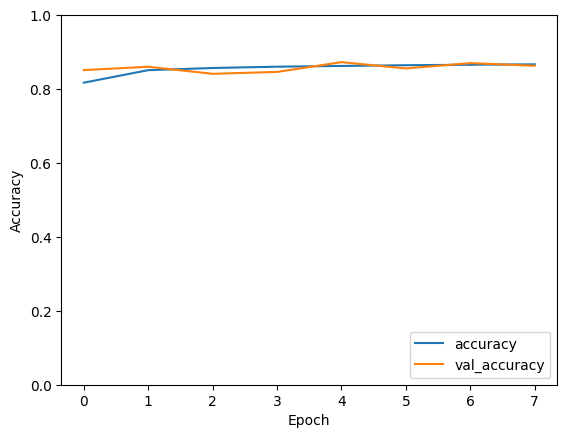

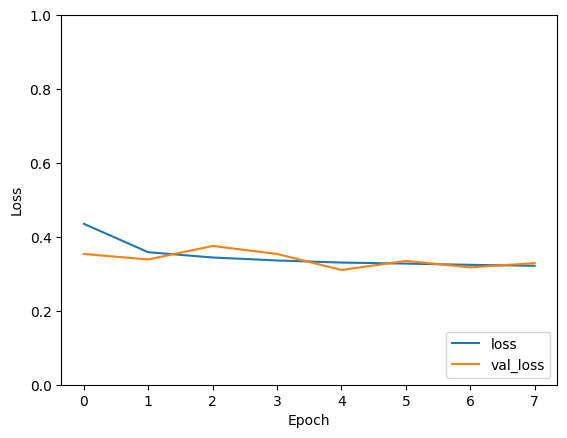

Final Test Accuracy: 0.8727


In [58]:

#plot the training and validation accuracy
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

#plot the training and validation loss
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

# Save model after training
model.save('best_model.keras', save_format='keras')

# Print final accuracy
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"Final Test Accuracy: {test_acc:.4f}")


In [ ]:
#more complex model lets see how it goes
def create_model():
    data_augmentation = tf.keras.Sequential([
        tf.keras.layers.RandomRotation(0.15),
        tf.keras.layers.RandomZoom(0.15),
        tf.keras.layers.RandomTranslation(0.15, 0.15),
        tf.keras.layers.RandomBrightness(0.1),
        tf.keras.layers.RandomContrast(0.1),
    ])
    
    model = tf.keras.models.Sequential([
        data_augmentation,
        
        # First Convolutional Block with Residual Connection
        tf.keras.layers.Conv2D(32, (3,3), padding='same', activation='relu', input_shape=(28,28,1)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(32, (3,3), padding='same', activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D((2,2)),
        tf.keras.layers.Dropout(0.2),
        
        # Second Convolutional Block
        tf.keras.layers.Conv2D(64, (3,3), padding='same', activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(64, (3,3), padding='same', activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D((2,2)),
        tf.keras.layers.Dropout(0.3),
        
        # Third Convolutional Block
        tf.keras.layers.Conv2D(128, (3,3), padding='same', activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(128, (3,3), padding='same', activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D((2,2)),
        tf.keras.layers.Dropout(0.4),
        
        # Dense Layers
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(5, activation='softmax')
    ])

    # Use a custom learning rate schedule
    initial_learning_rate = 0.001
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate,
        decay_steps=1000,
        decay_rate=0.9,
        staircase=True
    )

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

def train_model(model, X_train, X_test, y_train, y_test):
    # Define callbacks
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_accuracy',
        patience=8,
        restore_best_weights=True,
        min_delta=0.0005
    )

    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_accuracy',
        factor=0.5,
        patience=4,
        min_lr=0.00001,
        verbose=1
    )

    model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
        'best_model.keras',
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    )

    # Train the model
    batch_size = 64  # Increased batch size for faster training
    history = model.fit(
        X_train, y_train,
        epochs=50,  # Increased epochs since we have early stopping
        batch_size=batch_size,
        validation_data=(X_test, y_test),
        callbacks=[early_stopping, reduce_lr, model_checkpoint],
        verbose=1
    )

    return history

def evaluate_model(model, X_test, y_test, class_names):
    # Get predictions
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_test_classes = np.argmax(y_test, axis=1)

    # Print confusion matrix
    conf_matrix = tf.math.confusion_matrix(y_test_classes, y_pred_classes)
    print("\nConfusion Matrix:")
    print(conf_matrix.numpy())

    # Print classification report
    from sklearn.metrics import classification_report
    print("\nClassification Report:")
    print(classification_report(y_test_classes, y_pred_classes, target_names=class_names))

    # Test accuracy
    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
    print(f"\nFinal Test Accuracy: {test_acc:.4f}")

    return test_acc

def main():
    # Load and preprocess data
    print("Loading and preprocessing data...")
    X, y, CLASS_NAMES = load_and_preprocess_data()
    X_train, X_test, y_train, y_test = prepare_data(X, y)

    # Create and train model
    print("\nCreating and training model...")
    model = create_model()
    history = train_model(model, X_train, X_test, y_train, y_test)

    # Plot training history
    plot_training_history(history)

    # Evaluate model
    print("\nEvaluating model...")
    evaluate_model(model, X_test, y_test, CLASS_NAMES)

    # Load best model and evaluate
    best_model = tf.keras.models.load_model('best_model.keras')
    print("\nEvaluating best model...")
    best_acc = evaluate_model(best_model, X_test, y_test, CLASS_NAMES)

    print(f"\nBest model saved with accuracy: {best_acc:.4f}")

In [59]:
loss, acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {acc:.4f}")

model.save("shape_model.h5")
print("Model saved as shape_model.h5")

4207/4207 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.8724 - loss: 0.3090


Test Accuracy: 0.8727
Model saved as shape_model.h5


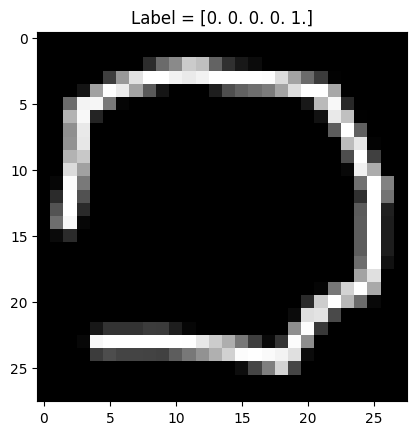

In [60]:
import matplotlib.pyplot as plt
# Plot a random sample of 10 test images, their predicted labels and ground truth
#['circle', 'square', 'triangle', 'hexagon', 'octagon'])
index = 1201
plt.imshow(X_train[index].squeeze(), cmap='gray')
plt.title(f"Label = {y_train[index]}")
plt.show()

In [61]:
# Example quick check
import numpy as np

preds = model.predict(X_test[:10])
pred_classes = np.argmax(preds, axis=1)
print("Predicted:", pred_classes)
print("True labels:", y_test[:10])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Predicted: [4 3 0 0 3 4 0 1 2 1]
True labels: [[0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0.]]
